# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [2]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.rolling_process.rolling_filter import *
from src.utils.analysis_basics import check_constrains as check

# Solver Model
from src.models.lp import lateness_scheduling as lp_late_schedule
from src.models.lp import lateness_rescheduling as lp_late_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [3]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*30     # 30 min

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [4]:
basic_data_path = get_path("data", "basic")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [5]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [6]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [7]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
7,J25-0007,5,925,1440,2930.0,496,2929
8,J25-0008,4,988,1440,2986.0,393,3541
9,J25-0009,7,1004,1440,3045.0,539,3578


In [8]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling

#### a) Summe der absoluten Lateness minimieren

$$
\min \sum_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen zur Deadline**, unabhängig davon, ob ein Job zu früh oder zu spät fertig wird.  
Sie fördert eine **gleichmäßige, zentrierte Fertigstellung** aller Jobs um ihre Soll-Zeitpunkte (Deadlines).

In [9]:
# Scheduling
df_schedule = lp_late_schedule.solve_jssp_sum(
    df_jssp_current, df_jobs_times_current, solver= "HiGHS",
    earliest_start_column = "Ready Time", msg=False, timeLimit=max_time, gapRel= 0.01
)
df_schedule

BigM: 6000

Solver-Informationen:
  Summe absolute Lateness  : 0.0
  Solver-Status            : Optimal
  Anzahl Variablen         : 1392
  Anzahl Constraints       : 2592
  Laufzeit                 : ~3 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J25-0000,8,0,M00,76,79,1440,3660,2783.0,2859.0,-801.0,801.0
1,J25-0000,8,1,M01,69,79,1440,3660,3001.0,3070.0,-590.0,590.0
2,J25-0000,8,2,M03,76,79,1440,3660,3070.0,3146.0,-514.0,514.0
3,J25-0000,8,3,M05,51,79,1440,3660,3146.0,3197.0,-463.0,463.0
4,J25-0000,8,4,M02,85,79,1440,3660,3197.0,3282.0,-378.0,378.0
5,J25-0000,8,5,M09,11,79,1440,3660,3282.0,3293.0,-367.0,367.0
...,...,...,...,...,...,...,...,...,...,...,...,...
154,J25-0015,5,4,M08,48,1436,1440,2981,2080.0,2128.0,-853.0,853.0
155,J25-0015,5,5,M09,72,1436,1440,2981,2128.0,2200.0,-781.0,781.0
156,J25-0015,5,6,M00,47,1436,1440,2981,2200.0,2247.0,-734.0,734.0


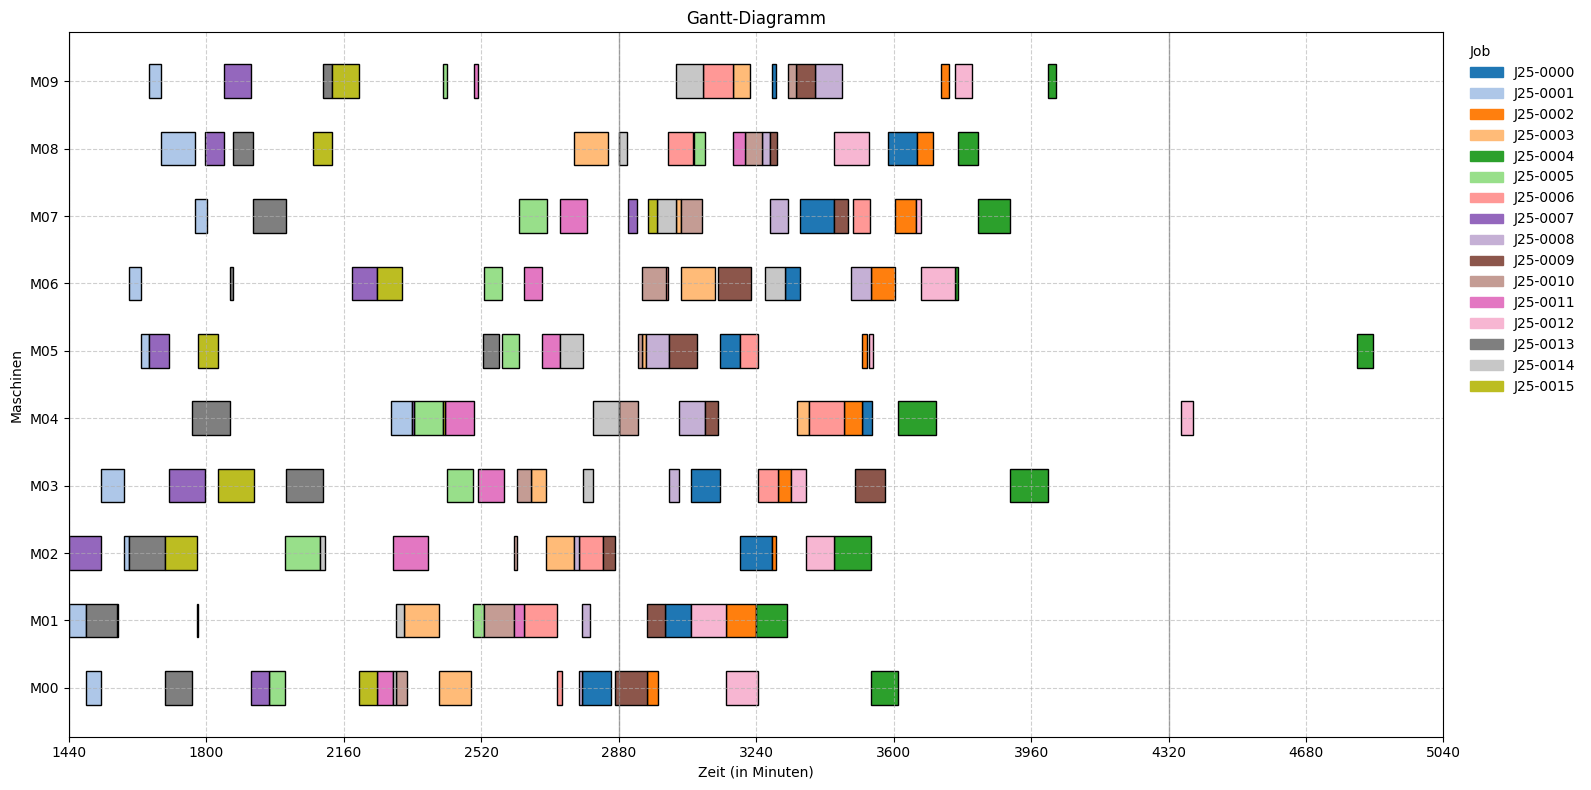

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
gantt.get_plot(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

### Simulation

In [11]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0001 started on M01
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:46:00] Job J25-0001 finished on M01 (after 46 minutes)
[Day 1 00:46:00] Job J25-0013 started on M01
[Day 1 00:46:00] Job J25-0001 started on M00
[Day 1 01:30:00] Job J25-0001 finished on M00 (after 44 minutes)
[Day 1 01:30:00] Job J25-0001 started on M03
[Day 1 01:31:00] Job J25-0007 finished on M02 (after 91 minutes)
[Day 1 02:04:00] Job J25-0013 finished on M01 (after 78 minutes)
[Day 1 02:07:00] Job J25-0007 started on M01
[Day 1 02:09:00] Job J25-0007 finished on M01 (after 02 minutes)
[Day 1 02:31:00] Job J25-0001 finished on M03 (after 61 minutes)
[Day 1 02:31:00] Job J25-0001 started on M02
[Day 1 02:42:00] Job J25-0001 finished on M02 (after 11 minutes)
[Day 1 02:42:00] Job J25-0013 started on M02
[Day 1 02:42:00] Job J25-0001 started on M06
[Day 1 03:19:00] Job J25-0001 finished on M06 (after 37 minutes)
[Day 1 03:19:00] Job J25-0001 started on M05
[Day 1 03:40:00] Job J25-0001 

In [12]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Routing_ID,Job,Operation,Machine,Arrival,Start,Processing Time,End
0,8,J25-0000,0,M00,79,2783.0,75.0,2858.0
1,6,J25-0001,0,M01,129,1440.0,46.0,1486.0
2,6,J25-0001,1,M00,129,1486.0,44.0,1530.0
3,6,J25-0001,2,M03,129,1530.0,61.0,1591.0
4,6,J25-0001,3,M02,129,1591.0,11.0,1602.0
5,6,J25-0001,4,M06,129,1602.0,37.0,1639.0
...,...,...,...,...,...,...,...,...
69,5,J25-0015,3,M03,1436,1840.0,103.0,1943.0
70,5,J25-0015,4,M08,1436,2080.0,41.0,2121.0
71,5,J25-0015,5,M09,1436,2128.0,85.0,2213.0


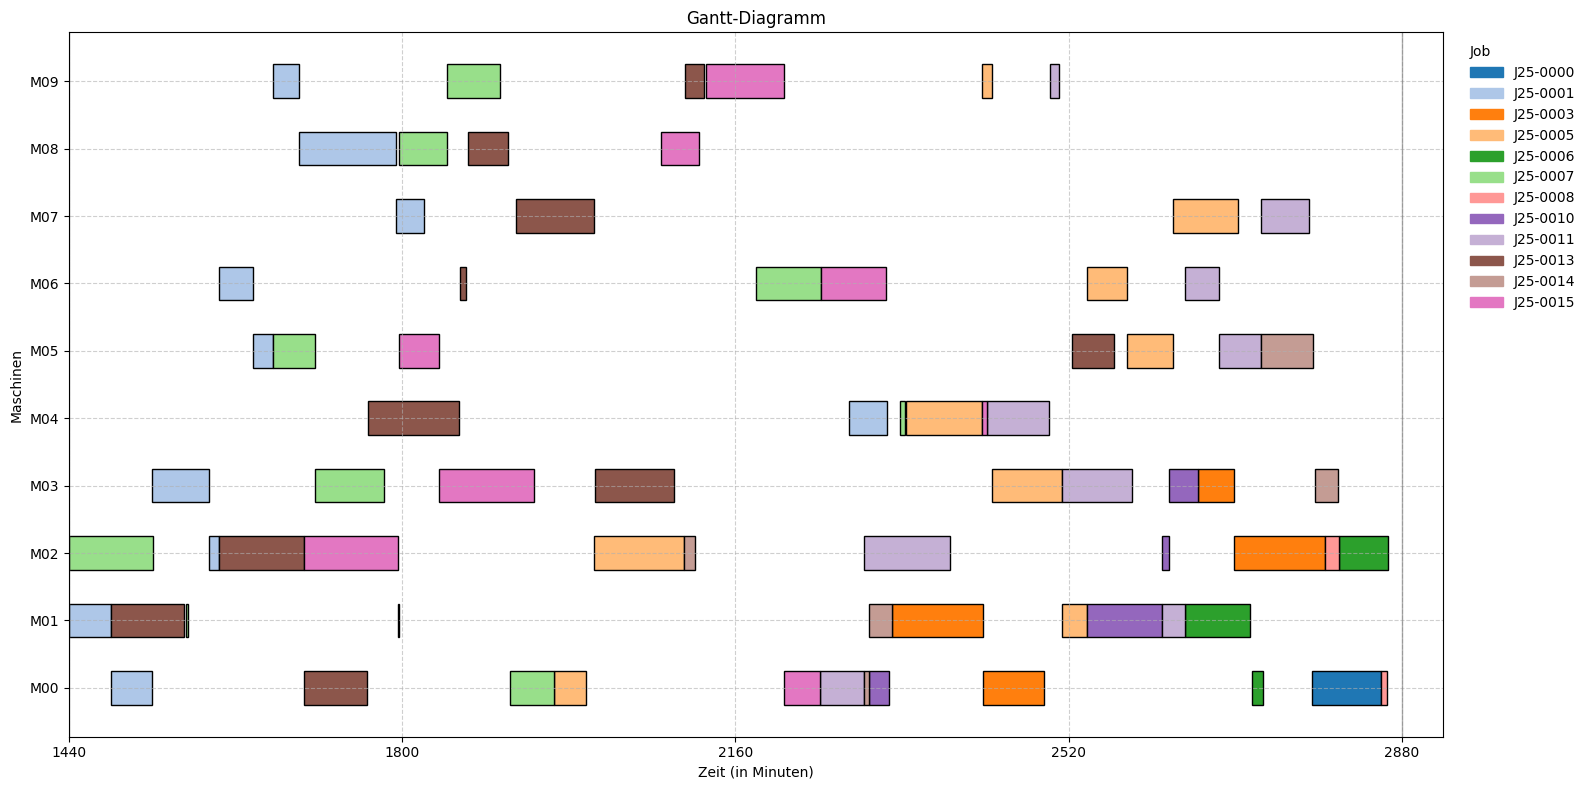

In [13]:
gantt.get_plot(df_execution, perspective="Machine")

In [14]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0003,4,M08,243,2797.0,90,87.0,2887.0,2884.0
1,J25-0008,2,M01,988,2864.0,22,21.0,2886.0,2885.0
2,J25-0009,0,M02,1004,2865.0,31,28.0,2896.0,2893.0
3,J25-0014,5,M04,1222,2812.0,69,78.0,2881.0,2890.0


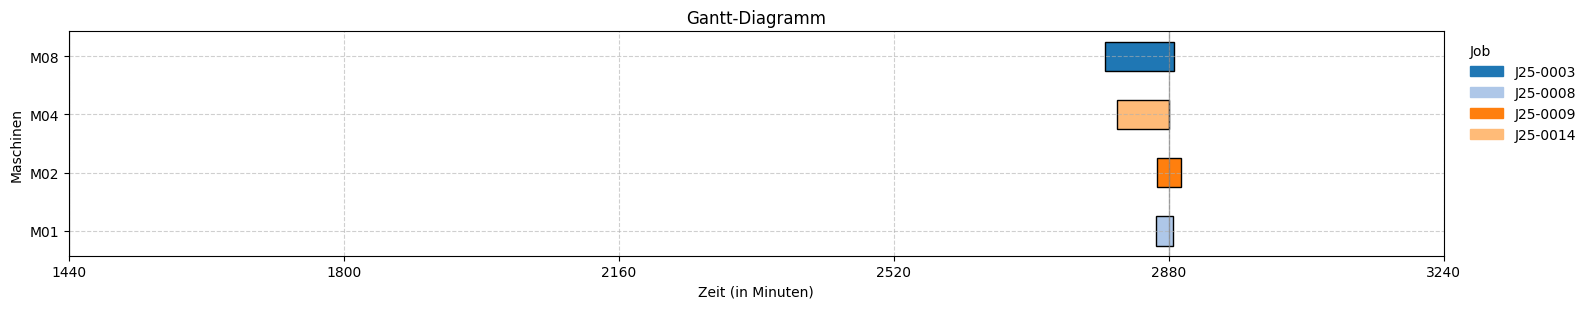

In [15]:
gantt.get_plot(df_active, perspective="Machine", duration_column="Planned Duration")

In [16]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J25-0000,8,1,M01,69,79,1440,3660,3001.0,3070.0,-590.0,590.0
1,J25-0000,8,2,M03,76,79,1440,3660,3070.0,3146.0,-514.0,514.0
2,J25-0000,8,3,M05,51,79,1440,3660,3146.0,3197.0,-463.0,463.0
3,J25-0000,8,4,M02,85,79,1440,3660,3197.0,3282.0,-378.0,378.0
4,J25-0000,8,5,M09,11,79,1440,3660,3282.0,3293.0,-367.0,367.0
5,J25-0000,8,6,M06,40,79,1440,3660,3315.0,3355.0,-305.0,305.0
...,...,...,...,...,...,...,...,...,...,...,...,...
75,J25-0012,2,9,M04,33,1103,1440,4385,4352.0,4385.0,0.0,0.0
76,J25-0014,4,6,M08,21,1222,1440,3315,2881.0,2902.0,-413.0,413.0
77,J25-0014,4,7,M07,49,1222,1440,3315,2981.0,3030.0,-285.0,285.0


#### b) größte absolute Lateness minimieren

$$
\min \; \max_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **größte Abweichung** eines Jobs zur Deadline – unabhängig davon, ob der Job **zu früh oder zu spät** fertiggestellt wurde.  
Sie sorgt dafür, dass **kein Job extrem abweicht**, und behandelt **Früh- und Spätfertigstellungen gleichwertig**.

In [17]:
# Scheduling
df_schedule_b = lp_late_schedule.solve_jssp_max(
    df_jssp_current, df_jobs_times_current, solver="HiGHS",
    earliest_start_column = "Ready Time", msg=False, timeLimit=max_time, gapRel=0.01)
df_schedule_b

BigM: 6000

Solver-Informationen:
  Maximale absolute Lateness : 0.0
  Solver-Status              : Optimal
  Anzahl Variablen           : 1393
  Anzahl Constraints         : 2608
  Laufzeit                   : ~3 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J25-0000,8,0,M00,76,79,1440,3660,2811.0,2887.0,0.0,0.0
1,J25-0000,8,1,M01,69,79,1440,3660,2887.0,2956.0,0.0,0.0
2,J25-0000,8,2,M03,76,79,1440,3660,2956.0,3032.0,0.0,0.0
3,J25-0000,8,3,M05,51,79,1440,3660,3032.0,3083.0,0.0,0.0
4,J25-0000,8,4,M02,85,79,1440,3660,3088.0,3173.0,0.0,0.0
5,J25-0000,8,5,M09,11,79,1440,3660,3298.0,3309.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
154,J25-0015,5,4,M08,48,1436,1440,2981,2003.0,2051.0,0.0,0.0
155,J25-0015,5,5,M09,72,1436,1440,2981,2123.0,2195.0,0.0,0.0
156,J25-0015,5,6,M00,47,1436,1440,2981,2195.0,2242.0,0.0,0.0


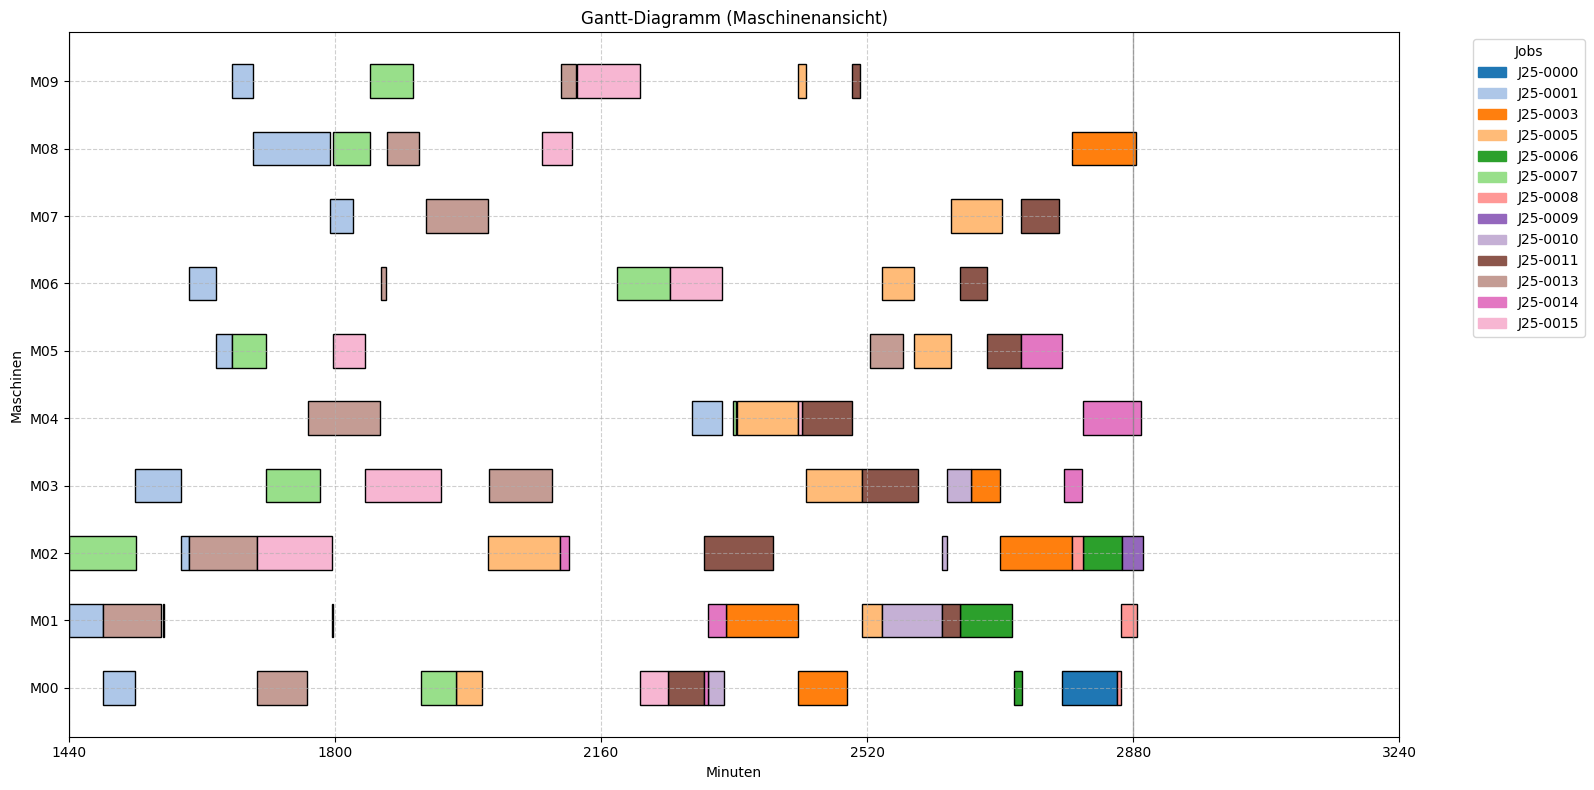

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [18]:
columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)

## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [19]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [20]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
...,...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,4856.0,416,3881
33,J25-0033,2,2660,2880,5305.0,568,6738
34,J25-0034,8,2715,2880,5271.0,597,6387


In [21]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
6,J25-0000,8,6,M06,40
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### a) einfache Neuplanung
- berücksichtigt lediglich die aktiven Arbeitsgänge (Operationen)

In [22]:
df_schedule_simple = lp_late_reschedule.solve_jssp_sum_with_fixed_ops(
    df_jssp_current, df_jobs_times_current, df_active,
    reschedule_start = day_start, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_simple

BigM: 12000

Solver-Informationen:
  Summe absolute Lateness  : 1734.0
  Solver-Status            : Optimal
  Anzahl Variablen         : 4908
  Anzahl Constraints       : 9479
  Laufzeit                 : ~1800 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J25-0000,8,1,M01,69,79,1440,3660,2885.0,2954.0,0.0,0.0
1,J25-0000,8,2,M03,76,79,1440,3660,2972.0,3048.0,0.0,0.0
2,J25-0000,8,3,M05,51,79,1440,3660,3167.0,3218.0,0.0,0.0
3,J25-0000,8,4,M02,85,79,1440,3660,3218.0,3303.0,0.0,0.0
4,J25-0000,8,5,M09,11,79,1440,3660,3303.0,3314.0,0.0,0.0
5,J25-0000,8,6,M06,40,79,1440,3660,3315.0,3355.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
295,J25-0037,7,4,M04,32,2801,2880,5173,4780.0,4812.0,0.0,0.0
296,J25-0037,7,5,M06,88,2801,2880,5173,4819.0,4907.0,0.0,0.0
297,J25-0037,7,6,M08,19,2801,2880,5173,4907.0,4926.0,0.0,0.0


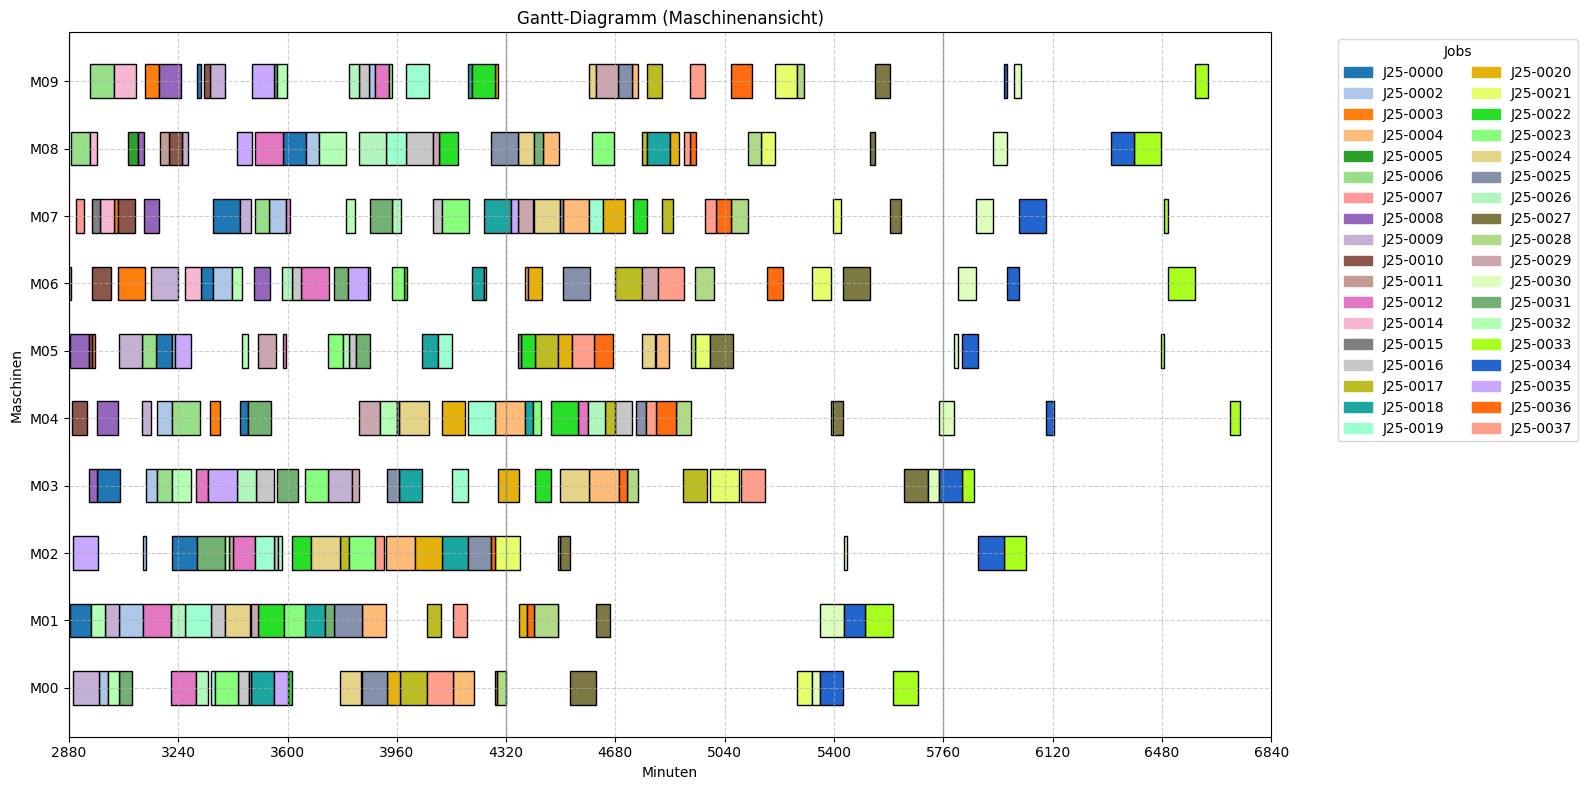

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
df_temp =  df_schedule_simple

gantt.get_plot(df_temp, perspective="Machine")
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

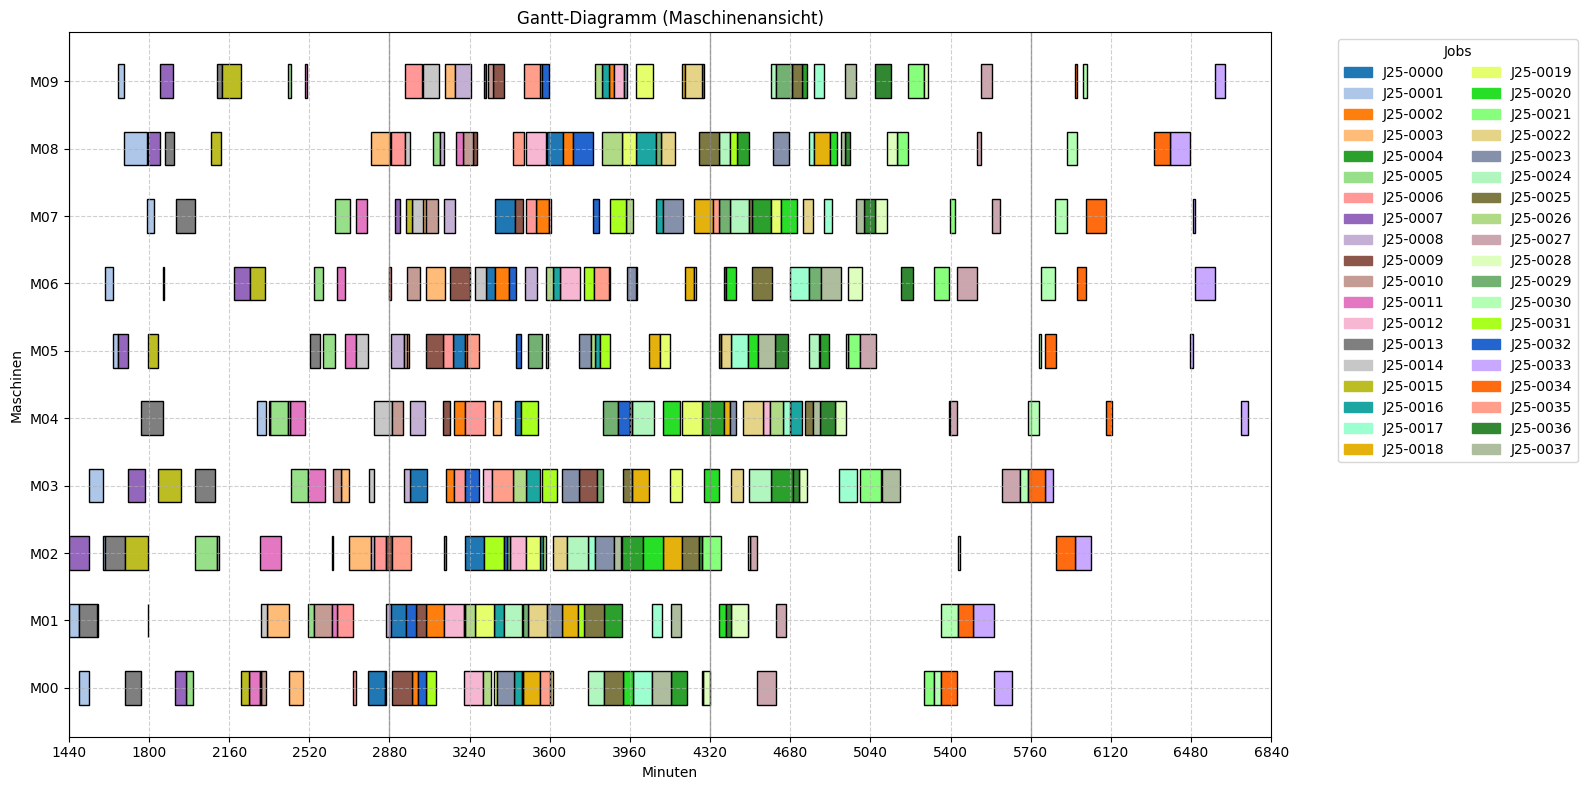

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [24]:
df_reschedule = df_schedule_simple

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### b) Neuplanung mit zusätzlich Minimierung der Planabweichung für die zuvor geplante Arbeitsgänge

In [25]:
df_schedule_devpen = lp_late_reschedule.solve_jssp_sum_with_devpen(
    df_jssp_current, df_jobs_times_current, df_active,
    df_original_plan = df_schedule,                     # prev. Plan
    r = 0.60,                                           # 60% Flowtime, 40% Abweichung
    reschedule_start = day_start, solver= "HiGHS",
    msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_devpen

BigM: 12000

Solver-Informationen:
  Zielfunktionswert         : 326.6
  Solver-Status             : Optimal
  Anzahl Variablen          : 4989
  Anzahl Constraints        : 9641
  Laufzeit                  : ~1800 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J25-0000,8,1,M01,69,79,1440,3660,2910.0,2979.0,0.0,0.0
1,J25-0000,8,2,M03,76,79,1440,3660,3046.0,3122.0,0.0,0.0
2,J25-0000,8,3,M05,51,79,1440,3660,3144.0,3195.0,0.0,0.0
3,J25-0000,8,4,M02,85,79,1440,3660,3196.0,3281.0,0.0,0.0
4,J25-0000,8,5,M09,11,79,1440,3660,3281.0,3292.0,0.0,0.0
5,J25-0000,8,6,M06,40,79,1440,3660,3315.0,3355.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
295,J25-0037,7,4,M04,32,2801,2880,5173,4735.0,4767.0,0.0,0.0
296,J25-0037,7,5,M06,88,2801,2880,5173,4767.0,4855.0,0.0,0.0
297,J25-0037,7,6,M08,19,2801,2880,5173,4855.0,4874.0,0.0,0.0


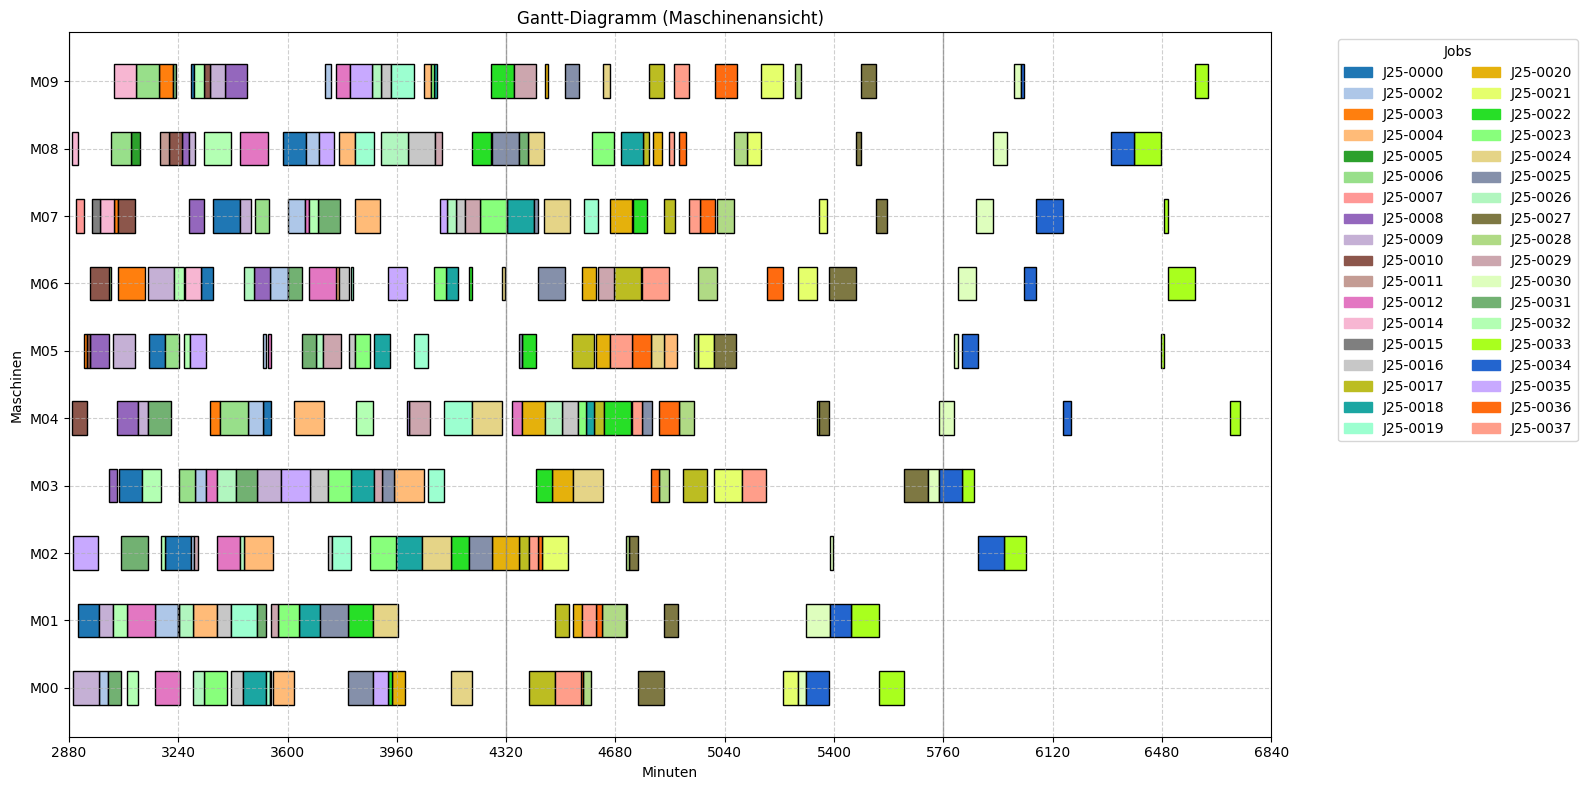

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [26]:
df_temp =  df_schedule_devpen

gantt.get_plot(df_temp, perspective="Machine")
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

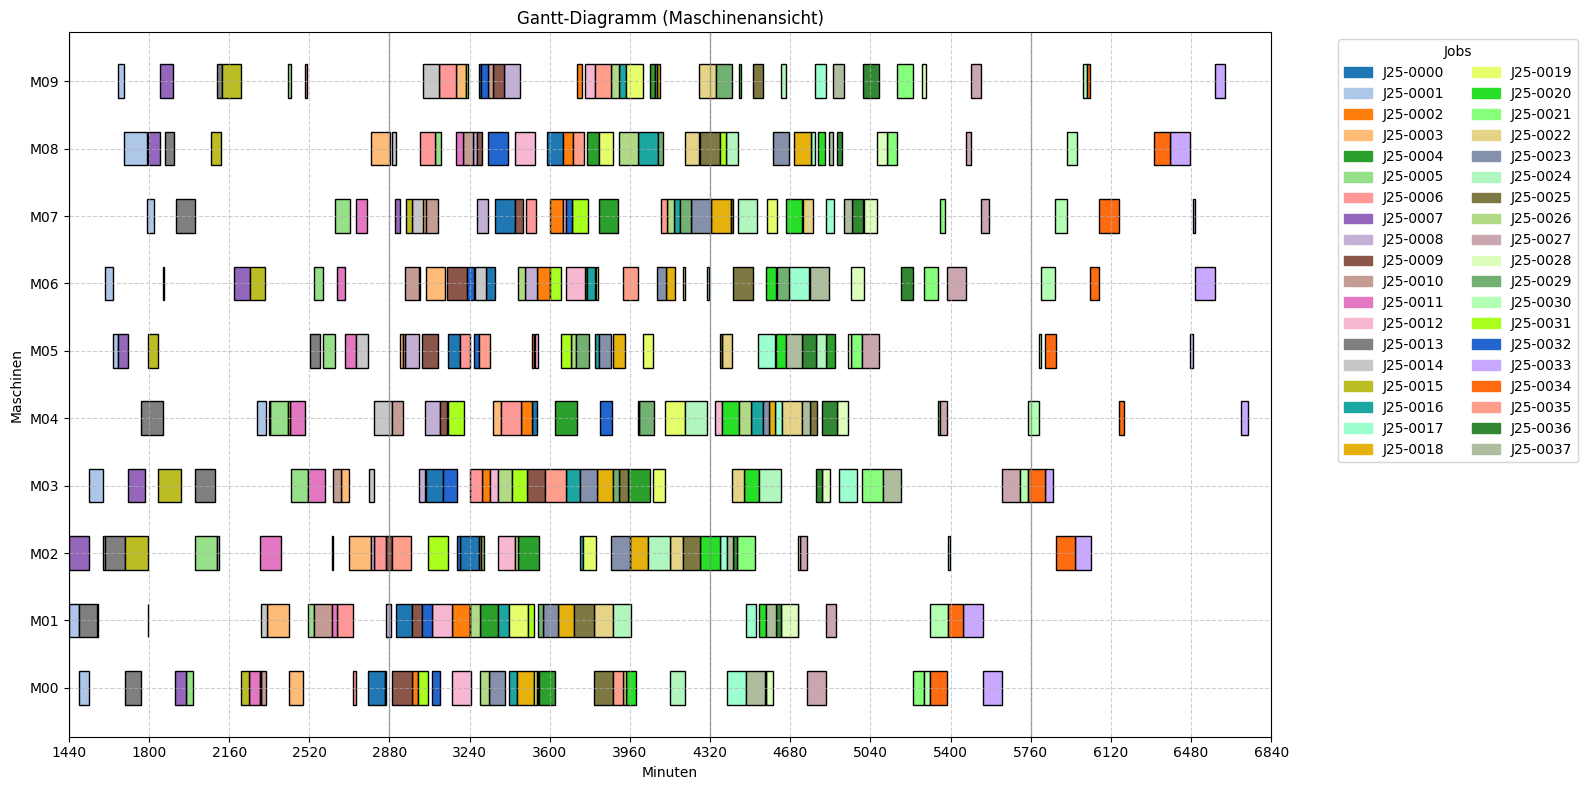

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [27]:
df_reschedule = df_schedule_devpen

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### Simulation

In [28]:
simulation.run(dframe_schedule_plan = df_schedule_devpen, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0003, Operation 4 resumed with 4.00 min
[Day 2 00:00:00] Job J25-0014, Operation 5 resumed with 10.00 min
[Day 2 00:00:00] Job J25-0008, Operation 2 resumed with 5.00 min
[Day 2 00:00:00] Job J25-0009, Operation 0 resumed with 13.00 min
[Day 2 00:04:00] Job J25-0003 finished on M08 (after 04 minutes)
[Day 2 00:05:00] Job J25-0008 finished on M01 (after 05 minutes)
[Day 2 00:10:00] Job J25-0014 finished on M04 (after 10 minutes)
[Day 2 00:10:00] Job J25-0010 started on M04
[Day 2 00:10:00] Job J25-0014 started on M08
[Day 2 00:13:00] Job J25-0009 finished on M02 (after 13 minutes)
[Day 2 00:13:00] Job J25-0009 started on M00
[Day 2 00:13:00] Job J25-0035 started on M02
[Day 2 00:24:00] Job J25-0007 started on M07
[Day 2 00:30:00] Job J25-0000 started on M01
[Day 2 00:31:00] Job J25-0014 finished on M08 (after 21 minutes)
[Day 2 00:49:00] Job J25-0003 started on M05
[Day 2 00:50:00] Job J25-0007 finished on M07 (after 26 minutes)
[Day 2 00:51:00] Job J25-0010 fin

In [29]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Operation,Machine,Arrival,Start,Processing Time,End,Routing_ID
0,J25-0000,1,M01,79,2910.0,79.0,2989.0,8.0
1,J25-0000,2,M03,79,3046.0,77.0,3123.0,8.0
2,J25-0000,3,M05,79,3144.0,52.0,3196.0,8.0
3,J25-0000,4,M02,79,3204.0,82.0,3286.0,8.0
4,J25-0000,5,M09,79,3286.0,9.0,3295.0,8.0
5,J25-0000,6,M06,79,3319.0,44.0,3363.0,8.0
...,...,...,...,...,...,...,...,...
168,J25-0035,4,M08,2726,3730.0,45.0,3775.0,5.0
169,J25-0035,5,M09,2726,3846.0,62.0,3908.0,5.0
170,J25-0035,6,M00,2726,3908.0,38.0,3946.0,5.0


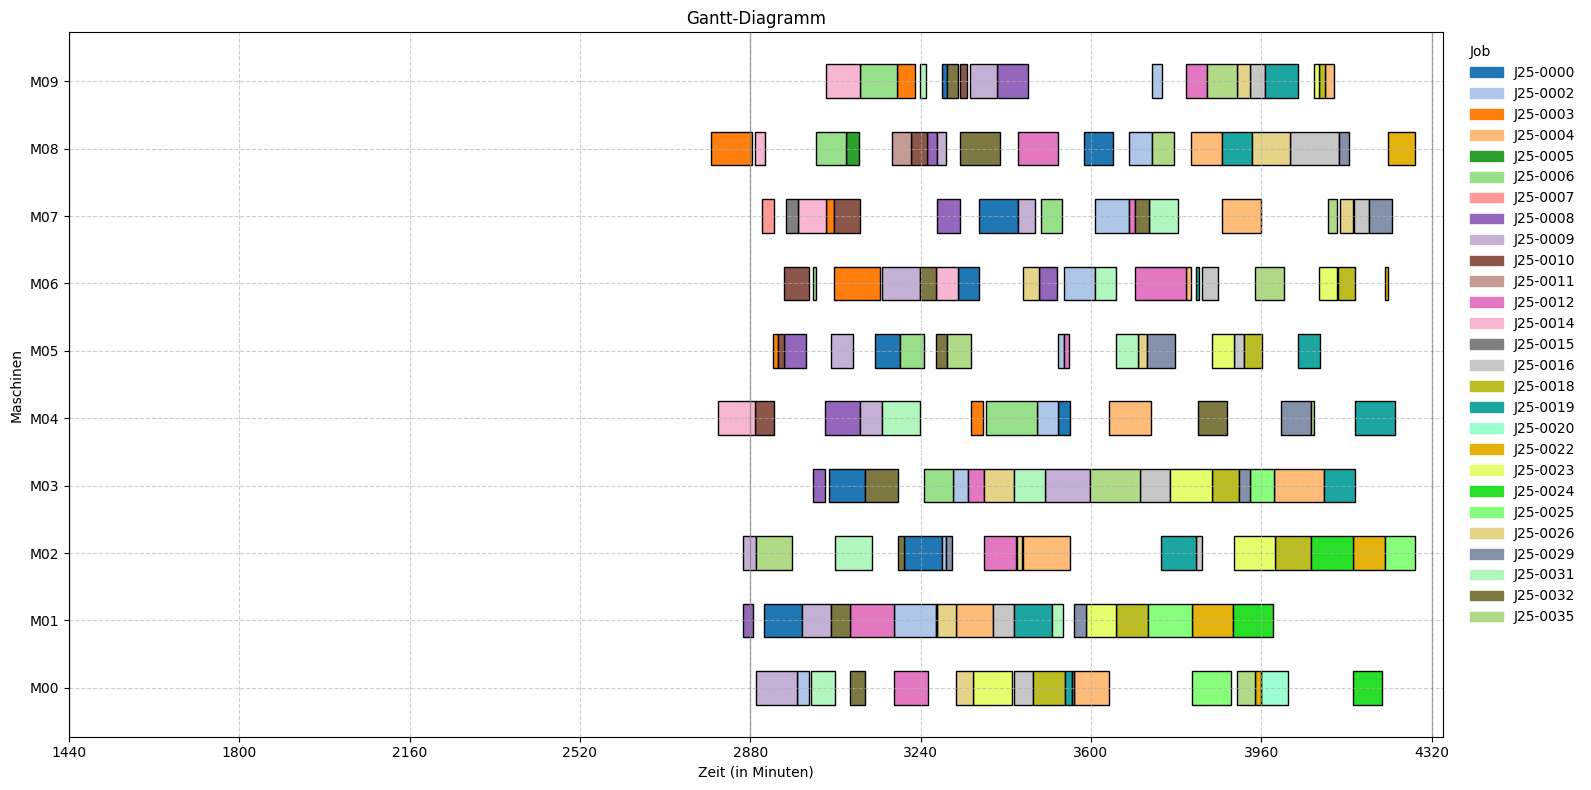

In [30]:
gantt.get_plot(df_execution2, perspective="Machine")

In [31]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0020,1,M02,1935,4284.0,90,107.0,4374.0,4391.0
1,J25-0022,5,M09,2001,4285.0,76,59.0,4361.0,4344.0
2,J25-0023,7,M07,2055,4236.0,89,85.0,4325.0,4321.0
3,J25-0024,3,M04,2108,4243.0,99,89.0,4342.0,4332.0
4,J25-0025,4,M08,2126,4285.0,90,101.0,4375.0,4386.0


In [32]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J25-0000,8,0,M00,76,79,1440,3660,2783.0,2859.0,-801.0,801.0
1,J25-0001,6,0,M01,46,129,1440,2338,1440.0,1486.0,-852.0,852.0
2,J25-0001,6,1,M00,37,129,1440,2338,1486.0,1523.0,-815.0,815.0
3,J25-0001,6,2,M03,61,129,1440,2338,1523.0,1584.0,-754.0,754.0
4,J25-0001,6,3,M02,13,129,1440,2338,1584.0,1597.0,-741.0,741.0
5,J25-0001,6,4,M06,32,129,1440,2338,1597.0,1629.0,-709.0,709.0
...,...,...,...,...,...,...,...,...,...,...,...,...
71,J25-0015,5,3,M03,95,1436,1440,2981,1830.0,1925.0,-1056.0,1056.0
72,J25-0015,5,4,M08,48,1436,1440,2981,2080.0,2128.0,-853.0,853.0
73,J25-0015,5,5,M09,72,1436,1440,2981,2128.0,2200.0,-781.0,781.0


#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

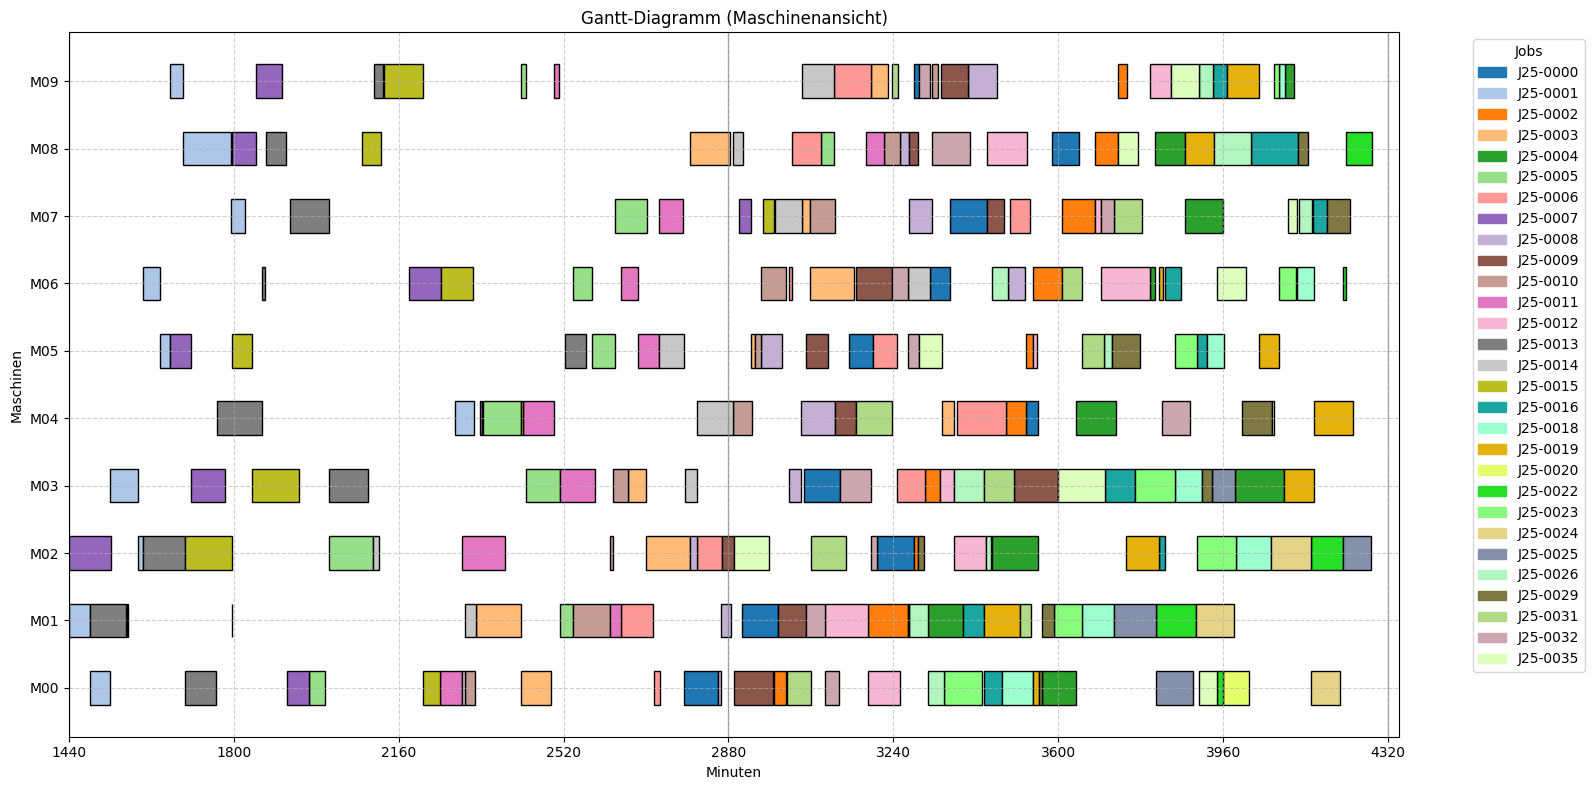

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [33]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)